In [1]:
from __future__ import division, print_function
import os
import sys
from datetime import datetime, timedelta


import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from scipy import stats
%matplotlib inline

from pyspark.sql import SparkSession

NUM_PARTITIONS = 1024
spark = ( SparkSession
             .builder
             .config("spark.app.name","BootstrappingConfig")
             .config("spark.yarn.queue","root.sp_analytics.spark")
             .config("spark.default.serializer","org.apache.spark.serializer.KryoSerializer")
             .config("spark.speculation","true")
             .config("spark.sql.autoBroadcastJoinThreshold","-1")
             .config("spark.default.parallelism",str(NUM_PARTITIONS))
             .config("spark.sql.shuffle.partitions",str(NUM_PARTITIONS))
             .config("spark.yarn.executor.memoryOverhead", str(8192))
             .enableHiveSupport()
             .getOrCreate() )

sc = spark.sparkContext

In [2]:
# put the table name of the bootstrapping result here
account = "account_4"
user_name = "lijia" # put in whichever user name, your own , or spmeta
# test = spark.sql("show tables in {0} like '{1}_bootstrapping_*'".format(user_name, account))
# table_name = test.orderBy(test.tableName.desc()).first().tableName
# res = spark.table("{0}.{1}".format(user_name,table_name)).cache() 
# metric_names = ['gross_bookings', 'gross_profit']

In [16]:
table_name =  "account_4_variance_reduction_20190129_nsalt_100"
res = spark.table("{0}.{1}".format(user_name,table_name)).cache() 
metric_names = ['nits_bookings', 'nits_profit']

In [17]:
res.show()

+---------+-------------+--------+----------+-------------------+-----------------+
|     salt|paired_groups|num_days|num_groups|rdiff_nits_bookings|rdiff_nits_profit|
+---------+-------------+--------+----------+-------------------+-----------------+
|B01010197|          0_1|       7|        20|       -0.016606772|     -0.008832712|
|B01010197|         0_10|       7|        20|        -0.10344684|     -0.019354215|
|B01010197|         0_11|       7|        20|       -0.014237369|      0.007004557|
|B01010197|         0_12|       7|        20|       -0.044180024|      -0.01583671|
|B01010197|         0_13|       7|        20|        0.014069967|     -0.025970824|
|B01010197|         0_14|       7|        20|       -0.027384141|     -0.008780562|
|B01010197|         0_15|       7|        20|        -0.06774719|     -0.040240597|
|B01010197|         0_16|       7|        20|         -0.0700498|     -0.018683935|
|B01010197|         0_17|       7|        20|        -0.09682327|     -0.012

In [18]:
# first generate the descriptives statistics of the empirical distribution 
num_days   = [7, 14, 21, 28]
quantile_table = pd.DataFrame()
for num_day in num_days:
    
    subdata = res.filter(res.num_days == num_day).toPandas()
    # manually filter out. 
    subdata = subdata[np.abs(subdata.rdiff_nits_profit)<5]
    # get the 'true' mean of the underlying distribution, assuming it is the true after resampling many times 
    global_mean = ( subdata.groupby(["num_groups"],as_index=False)
                                                .agg({'rdiff_' + m:"mean" for m in metric_names}) )
    global_mean.columns = ['num_groups'] + metric_names
    subdata = ( subdata.merge(global_mean,on="num_groups",how="inner") )
    # empirical bootstrap step here: 
    for m in metric_names:
        subdata["eb_"+m] = subdata['rdiff_' + m] - subdata[m] 
    quantile_table = quantile_table.append( subdata.groupby(["num_days", "num_groups"],as_index=False)
                                           .quantile(q = [0.025, 0.975]).round(3)
                                           [['num_groups', "num_days"] + ['eb_' + m for m in metric_names]]
                                          )


quantile_table.index      = quantile_table.index.set_names('CI', level = 1)
quantile_table            = quantile_table.reset_index(level = 1)
quantile_table.CI         = (quantile_table.CI * 100).astype(str) + '%'
quantile_table.num_days   = quantile_table.num_days.astype(int)
quantile_table.num_groups = quantile_table.num_groups.astype(int)
quantile_table.columns = ["Confidence Interval", "Number of Groups", "Number of Days", 
                          "Bootstrapped Relative difference {0}".format(metric_names[0]),
                          "Bootstrapped Relative Difference {0}".format(metric_names[1])]

In [19]:
quantile_table

,Confidence Interval,Number of Groups,Number of Days,Bootstrapped Relative difference nits_bookings,Bootstrapped Relative Difference nits_profit
0,2.5%,2,7,-0.043,-0.015
0,97.5%,2,7,0.034,0.017
1,2.5%,4,7,-0.053,-0.032
1,97.5%,4,7,0.052,0.031
2,2.5%,10,7,-0.075,-0.052
2,97.5%,10,7,0.086,0.048
3,2.5%,20,7,-0.101,-0.080
3,97.5%,20,7,0.133,0.067
0,2.5%,2,14,-0.033,-0.012
0,97.5%,2,14,0.024,0.015


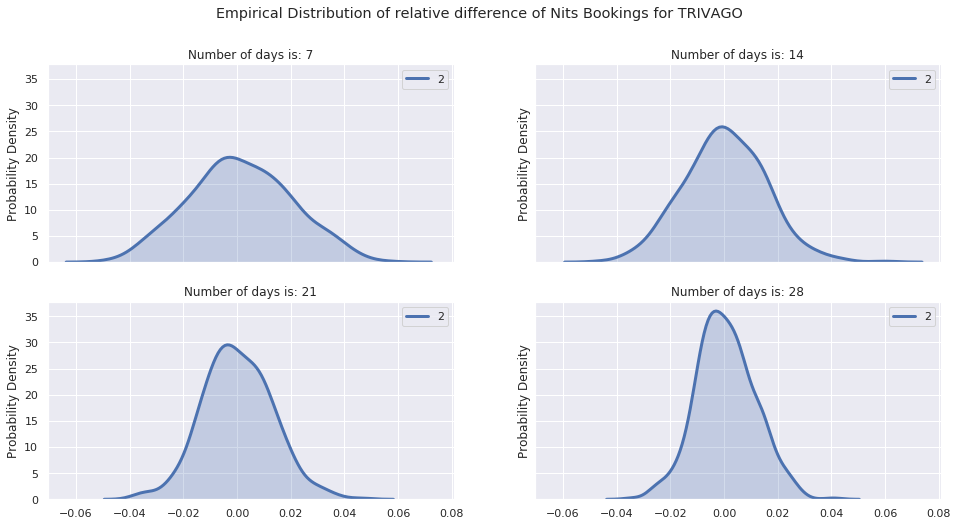

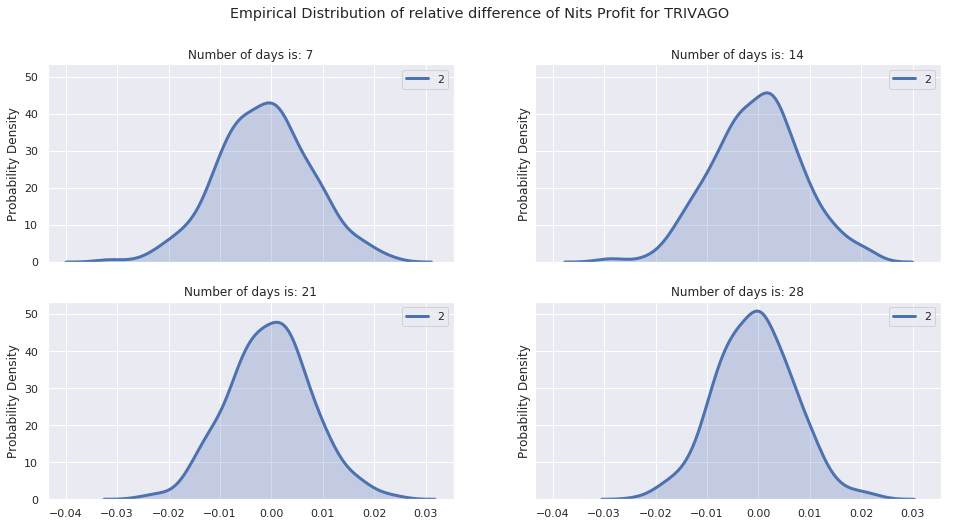

In [11]:
# generate the plots
num_days   = [7, 14, 21, 28]
num_groups = [2]

for metric_name in metric_names: 
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 8), sharex=True, sharey = True)
    fig.suptitle('Empirical Distribution of relative difference of {1} for {0}'.format(account.upper(), 
                                                                    ' '.join(m.capitalize() for m in metric_name.split("_")))
                ,fontsize="x-large")
    for i, num_day in enumerate(num_days):
        # get the column index for the graph 
        row = i // 2
        col = i % 2
        ax_curr = axes[row, col]
        subday = res.filter(res.num_days == num_day).toPandas()
        subday = subday[np.abs(subday['rdiff_' + metric_name])<5]
        # get the 'true' mean of the underlying distribution, assuming it is the true after resampling many times 
        global_mean = ( subday.groupby(["num_groups"],as_index=False)
                                                    .agg({'rdiff_' + m:"mean" for m in metric_names}) )
        global_mean.columns = ['num_groups'] + metric_names
        subday = ( subday.merge(global_mean,on="num_groups",how="inner") )
        subday["eb_"+metric_name] = subday['rdiff_' + metric_name] - subday[metric_name] 
        
        for num_group in num_groups:
            # Subset to each group 
            subgroup = subday[subday['num_groups'] == num_group]
            # Draw the density plot
            sns.distplot(subgroup['eb_{0}'.format(metric_name)], hist = False, kde = True,
                         kde_kws = {'shade': True,'linewidth': 3}, 
                         label = num_group, 
                         ax=ax_curr)
        ax_curr.set_title('Number of days is: {0}'.format(num_day))
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('Probability Density')

    fig.savefig('{0}_{1}.png'.format(account, metric_name)) 


In [23]:
### look at random 500 salts 
table_name =  "account_4_bootstrapping_20190128_nsalt_500"
res = spark.table("{0}.{1}".format(user_name,table_name)).cache() 
metric_names = ['nits_bookings', 'nits_profit']

In [24]:
# first generate the descriptives statistics of the empirical distribution 
num_days   = [7, 14, 21, 28]
quantile_table = pd.DataFrame()
for num_day in num_days:
    
    subdata = res.filter(res.num_days == num_day).toPandas()
    # manually filter out. 
    subdata = subdata[np.abs(subdata.rdiff_nits_profit)<5]
    # get the 'true' mean of the underlying distribution, assuming it is the true after resampling many times 
    global_mean = ( subdata.groupby(["num_groups"],as_index=False)
                                                .agg({'rdiff_' + m:"mean" for m in metric_names}) )
    global_mean.columns = ['num_groups'] + metric_names
    subdata = ( subdata.merge(global_mean,on="num_groups",how="inner") )
    # empirical bootstrap step here: 
    for m in metric_names:
        subdata["eb_"+m] = subdata['rdiff_' + m] - subdata[m] 
    quantile_table = quantile_table.append( subdata.groupby(["num_days", "num_groups"],as_index=False)
                                           .quantile(q = [0.025, 0.975]).round(3)
                                           [['num_groups', "num_days"] + ['eb_' + m for m in metric_names]]
                                          )


quantile_table.index      = quantile_table.index.set_names('CI', level = 1)
quantile_table            = quantile_table.reset_index(level = 1)
quantile_table.CI         = (quantile_table.CI * 100).astype(str) + '%'
quantile_table.num_days   = quantile_table.num_days.astype(int)
quantile_table.num_groups = quantile_table.num_groups.astype(int)
quantile_table.columns = ["Confidence Interval", "Number of Groups", "Number of Days", 
                          "Bootstrapped Relative difference {0}".format(metric_names[0]),
                          "Bootstrapped Relative Difference {0}".format(metric_names[1])]

In [25]:
quantile_table

,Confidence Interval,Number of Groups,Number of Days,Bootstrapped Relative difference nits_bookings,Bootstrapped Relative Difference nits_profit
0,2.5%,2,7,-0.032,-0.023
0,97.5%,2,7,0.037,0.023
1,2.5%,4,7,-0.050,-0.034
1,97.5%,4,7,0.055,0.030
2,2.5%,10,7,-0.075,-0.054
2,97.5%,10,7,0.092,0.048
3,2.5%,20,7,-0.099,-0.077
3,97.5%,20,7,0.132,0.066
0,2.5%,2,14,-0.027,-0.024
0,97.5%,2,14,0.033,0.020
